#**Simple ANN (Art. Neural Net) Example - Rolling Window Prediction for ML-powered Stock Trading**

C Kaligotla

Feb 03, 2025

Note: This is time series data - Refer Class Slides for more details

Reference: Adopted from Dr. Frederick's code

# PREAMBLE

In [1]:
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

# CONSTANTS AND INPUTS

In [3]:
# Constants
TICKER = "AAPL"
START_DATE = '2024-03-01'
END_DATE = '2025-03-01'
LOOK_BACK = 60
INITIAL_BALANCE = 10000.0
EPOCHS = 100
BATCH_SIZE = 32

# FUNCTIONS

### Data Fetching and Data Preparation:

fetch_stock_data - Fetches historical stock data for a given ticker and date range using the yfinance library.

Data Preparation:
prepare_data_without_scaling - This function prepares the data by creating sequences of look_back days as input
and predicting the next day's close price.

In [4]:
def fetch_stock_data(ticker=TICKER, start_date=START_DATE, end_date=END_DATE):
    return yf.download(ticker, start=start_date, end=end_date)


def prepare_data_without_scaling(data, look_back):
    # Preparing data without scaling to avoid data leakage
    close_prices = data['Close'].values.reshape(-1, 1)

    X, y = [], []
    for i in range(look_back, len(close_prices)):
        X.append(close_prices[i - look_back:i, 0])
        y.append(close_prices[i, 0])

    return np.array(X), np.array(y)

### Data Splitting:

split_data - Splits the data into training and testing sets based on a given ratio (default is 0.8).


In [5]:
def split_data(X, y, ratio=0.8):
    train_size = int(len(X) * ratio)
    return X[:train_size], X[train_size:], y[:train_size], y[train_size:]

### Model Building:

build_model - Constructs a simple feed-forward neural network using Keras with 3 hidden layers.


In [6]:
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

### Rolling_prediction -

For each data point in X_test, this function predicts the next day's stock price.


In [7]:
def rolling_prediction(model, X_test, look_back, steps_ahead=1):
    test_predictions = []

    for i in range(0, len(X_test) - steps_ahead + 1):
        current_batch = X_test[i].reshape(1, look_back)
        for j in range(steps_ahead):
            current_pred = model.predict(current_batch)[0]
            test_predictions.append(current_pred)

            # Shift the batch left by one step
            current_batch = np.roll(current_batch, -1)

            # If not the last step, insert the predicted value for the next prediction
            if j < steps_ahead - 1:
                current_batch[-1][-1] = current_pred

    return test_predictions


### Trading Strategy:

trading_strategy - Implements a basic trading strategy where stocks are bought if the predicted price for the next day is higher than the current day and sold otherwise.

It returns the final balance after performing all
these trades.


In [8]:
def trading_strategy(y_test_original, test_predictions_original):
    initial_balance = 10000.0
    balance = initial_balance
    stock_count = 0
    buy_points, sell_points, account_values = [], [], []
    for i in range(len(y_test_original) - 1):
        today_price = y_test_original[i][0]
        predicted_next_day_price = test_predictions_original[i + 1][0]
        account_values.append(balance + stock_count * today_price)

        if predicted_next_day_price > today_price and balance > today_price and stock_count == 0:
            stock_count += 1
            balance -= today_price
            buy_points.append((i, today_price))
        elif predicted_next_day_price < today_price and stock_count > 0:
            stock_count -= 1
            balance += today_price
            sell_points.append((i, today_price))

    # Sell if stock remaining
    if stock_count == 1:
        balance += y_test_original[-1][0]
    account_values.append(balance)  # add the final account value

    return balance, buy_points, sell_points, account_values

# MAIN

Main Execution:

Here, the data is fetched, prepared, split, scaled, the model is trained and evaluated. Finally, the trading strategy is implemented, and the results are plotted.

In [9]:
# Fetch and prepare data
data = fetch_stock_data()
X, y = prepare_data_without_scaling(data, LOOK_BACK)
X_train, X_test, y_train, y_test = split_data(X, y)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Fetch and prepare data without scaling initially to avoid data leakage.

It's essential to split the data into training and test sets before applying any transformations.

By doing this, we ensure that the training data transformations don't have any knowledge of the test data, which is a form of data leakage.

In [10]:
# Scaling the data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

In [11]:
# Train model
model = build_model(LOOK_BACK)
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/100
5/5 [==============================] - 1s 3ms/step - loss: 0.0786
Epoch 2/100
5/5 [==============================] - 0s 0s/step - loss: 0.0234
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 4/100
5/5 [==============================] - 0s 0s/step - loss: 0.0105
Epoch 5/100
5/5 [==============================] - 0s 0s/step - loss: 0.0088
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0063
Epoch 7/100
5/5 [==============================] - 0s 0s/step - loss: 0.0069
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 9/100
5/5 [==============================] - 0s 0s/step - loss: 0.0041
Epoch 10/100
5/5 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 11/100
5/5 [==============================] - 0s 0s/step - loss: 0.0035
Epoch 12/100
5/5 [==============================] - 0s 0s/step - loss: 0.0034
Epoch 13/100
5/5 [==============================] - 0s 0s/step - los

In [12]:
# Test the model
test_predictions = rolling_prediction(model, X_test, LOOK_BACK)
test_predictions_original = scaler_y.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test)


1/1 [==============================] - 0s 17ms/step


In [13]:
# Implement trading strategy
final_balance, buy_points, sell_points, account_values = trading_strategy(y_test_original, test_predictions_original)


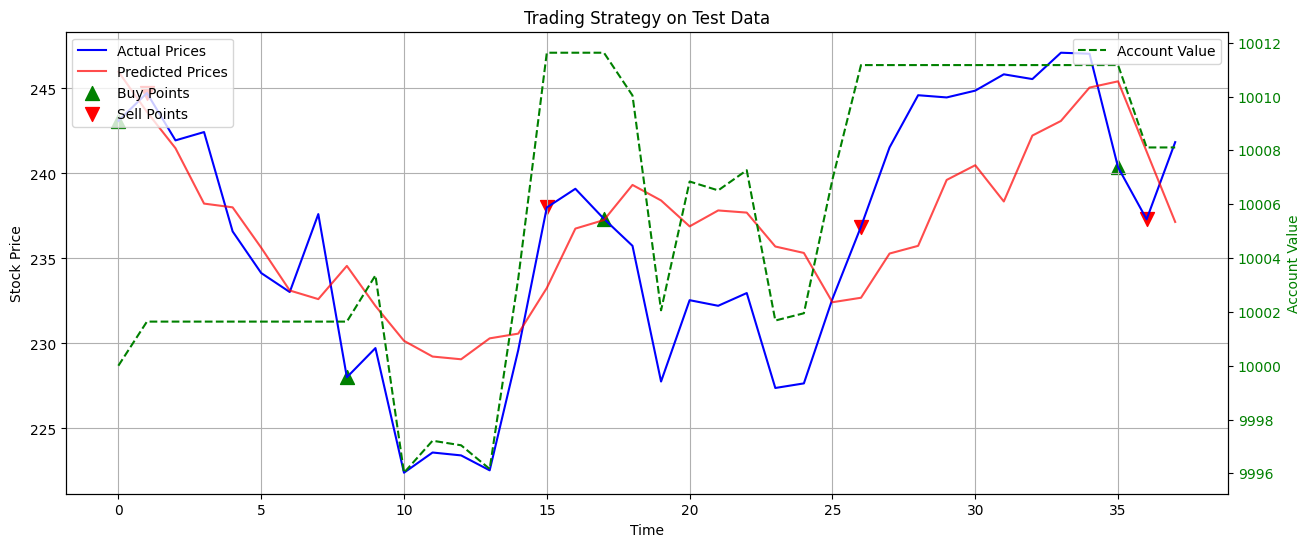

In [14]:
# Plot results
buy_indices, buy_prices = zip(*buy_points) if buy_points else ([], [])
sell_indices, sell_prices = zip(*sell_points) if sell_points else ([], [])

plt.figure(figsize=(15, 6))
ax1 = plt.gca()  # get current axis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.plot(y_test_original, label="Actual Prices", color="blue")
ax1.plot(test_predictions_original, label="Predicted Prices", color="red", alpha=0.7)
ax1.scatter(buy_indices, buy_prices, color="green", marker="^", alpha=1, label="Buy Points", s=100)
ax1.scatter(sell_indices, sell_prices, color="red", marker="v", alpha=1, label="Sell Points", s=100)
ax1.set_title("Trading Strategy on Test Data")
ax1.set_xlabel("Time")
ax1.set_ylabel("Stock Price")
ax1.legend(loc='upper left')
ax1.grid(True)

ax2.plot(account_values, label="Account Value", color="green", linestyle='--')
ax2.set_ylabel("Account Value", color="green")
ax2.tick_params(axis='y', labelcolor="green")
ax2.legend(loc='upper right')

plt.show()